In [1]:
from pathlib import Path
import numpy as np

from my_types import Vec3, Quat, ScalarBatch
from my_types import as_vec3
from io_csv import load_gyro_base, load_ref, load_acc, load_grav_ref, load_acc_lin_ref
from pipelines import integrate_gyro_acc
from evaluation import calc_angle_err, print_err_status, save_err_csv,plot_err_from_csv, save_estimated_vec3_csv
from evaluation import evaluate_estimated_vec3_autosign

EPS: float = 1e-9

In [2]:
root: Path = Path.cwd().parent
run_dir: Path = root / "data" / "21:08_oct_07_2025_5min"

ori_path: Path = run_dir / "Orientation.csv"
gyro_path: Path = run_dir / "Gyroscope.csv"
grav_path: Path = run_dir / "Gravity.csv"
acc_path: Path = run_dir / "AccelerometerUncalibrated.csv"
acc_lin_path: Path = run_dir / "Accelerometer.csv"

for p in [ori_path, gyro_path, grav_path, acc_path, acc_lin_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

In [3]:
t_src_gyro, w_src_gyro, dt, t_new, w_avg_gyro = load_gyro_base(gyro_path)

q_ref_interp = load_ref(ori_path, t_new)
q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

a_src_interp = load_acc(acc_path, t_new)

In [4]:
q0: Quat = q_ref_interp[0].copy()

K: float = 0.05
g0: float = 9.80665
acc_gate_sigma: float = 1.7
gyro_gate_sigma: float = 0.06 # 0.05-0.15?
g_world_unit: Vec3 = as_vec3(np.array([0, 0, -1]))
q_gyro_acc, g_body_est, a_lin_est = integrate_gyro_acc(q0, w_avg_gyro, dt,
                                                       K, g0, g_world_unit,
                                                       acc_gate_sigma, gyro_gate_sigma, a_src_interp)

angle_err_gyro_acc: ScalarBatch = calc_angle_err(q_gyro_acc, q_ref_interp)
print_err_status("Gyro + Acc", angle_err_gyro_acc)

Gyro + Acc angle error in rad — min/max/mean
0.008169541789927152 0.9530600440361652 0.19604139752366417

Gyro + Acc angle error in deg — min/max/mean
0.46808026511857803 54.60631814582465 11.232344687952386


In [5]:
out_dir: Path = root / "output"
out_dir.mkdir(parents=True, exist_ok=True)
out_path: Path = out_dir / "03_angle_err_gyro_acc.csv"
save_err_csv(out_path, t_new, angle_err_gyro_acc)

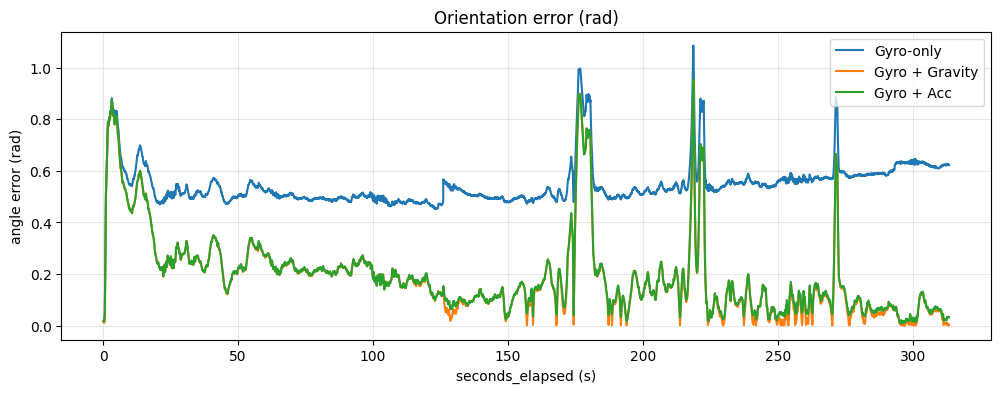

In [6]:
out_gyro_path = out_dir / "01_angle_err_gyro.csv"
out_grav_path = out_dir / "02_angle_err_gyro_grav.csv"
out_acc_path = out_dir / "03_angle_err_gyro_acc.csv"

plot_err_from_csv([
        ("Gyro-only", out_gyro_path),
        ("Gyro + Gravity", out_grav_path),
        ("Gyro + Acc", out_acc_path)
])

In [7]:
est_dir: Path = root / "estimate"
est_dir.mkdir(parents=True, exist_ok=True)

print("Gravity:")
g_ref_interp = load_grav_ref(grav_path, t_new)
g_est_sign_fixed, g_rmse_norm = evaluate_estimated_vec3_autosign(g_body_est, g_ref_interp)
print("")

print("Linear Acc:")
a_lin_ref_interp = load_acc_lin_ref(acc_lin_path, t_new)
a_lin_est_sign_fixed, a_lin_rmse_norm = evaluate_estimated_vec3_autosign(a_lin_est, a_lin_ref_interp)
print("")

save_estimated_vec3_csv(est_dir / "03_gravity_estimated.csv", t_new, g_est_sign_fixed)
save_estimated_vec3_csv(est_dir / "03_linear_acc_estimated.csv", t_new, a_lin_est_sign_fixed)

print("consistency ratio (a_lin / g):", a_lin_rmse_norm / max(g_rmse_norm, EPS))

Gravity:
RMSE norm: 0.336503201433378

Linear Acc:
RMSE norm: 0.814837748552808

consistency ratio (a_lin / g): 2.4214858731860605


In [8]:
import numpy as np

def unit(v):
    n = np.linalg.norm(v, axis=1, keepdims=True)
    return v / np.maximum(n, 1e-12)

def gravity_direction_angle_err(g_est: np.ndarray, g_ref: np.ndarray):
    ge = unit(g_est)
    gr = unit(g_ref)
    c = np.sum(ge * gr, axis=1)
    c = np.clip(c, -1.0, 1.0)
    ang = np.arccos(c)  # rad
    print("gravity dir angle err (rad): min/max/mean",
          float(ang.min()), float(ang.max()), float(ang.mean()))
    print("gravity dir angle err (deg): min/max/mean",
          float(np.rad2deg(ang.min())), float(np.rad2deg(ang.max())), float(np.rad2deg(ang.mean())))
    return ang

def accel_gravity_alignment(a_src: np.ndarray, g_est: np.ndarray, g0: float, thr: float = 0.3):
    a_norm = np.linalg.norm(a_src, axis=1)
    mask = np.abs(a_norm - g0) < thr

    au = unit(a_src)
    gu = unit(g_est)
    dot = np.sum(au * gu, axis=1)  # 부호는 플랫폼 정의에 따라 +/-1이 목표

    d = dot[mask]
    print(f"stationary mask count: {int(mask.sum())}/{len(mask)}")
    print("dot(a_unit, g_unit) on stationary: mean/min/max",
          float(np.mean(d)), float(np.min(d)), float(np.max(d)))
    return dot, mask

gravity_direction_angle_err(g_est_sign_fixed, g_ref_interp)
print("=============")
accel_gravity_alignment(a_src_interp, g_est_sign_fixed, g0)
print("=============")

gravity dir angle err (rad): min/max/mean 0.00029964843156482274 0.10452374071678129 0.030766968145712156
gravity dir angle err (deg): min/max/mean 0.01716859046637902 5.988769201991286 1.762817423162751
stationary mask count: 2778/30738
dot(a_unit, g_unit) on stationary: mean/min/max 0.9814861282495907 0.25550835816482276 0.9999997918654192
